# Text Classification with Bag of Words - Natural Language Processing

![](https://i.imgur.com/hlEQ5X8.png)

> _"Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data."_ - Wikipedia

> _**Bag of Words**: The bag-of-words (BOW) model is a representation that turns arbitrary text into fixed-length vectors by counting how many times each word appears._
 
Outline:

1. Download and explore a real-world dataset
2. Apply text preprocessing techniques
3. Implement the bag of words model
4. Train ML models for text classification
5. Make predictions and submit to Kaggle


Dataset: https://www.kaggle.com/c/quora-insincere-questions-classification


## General Description
In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
<br>

- Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype<br>
Makes disparaging attacks/insults against a specific person or group of people<br>
Based on an outlandish premise about a group of people<br>
Disparages against a characteristic that is not fixable and not measurable<br>
<br>

- Isn't grounded in reality<br>
Based on false information, or contains absurd assumptions
<br>

- Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers<br>
<br>

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

In [41]:
from __future__ import (annotations, print_function,)

%matplotlib inline
import re
from typing import List

import pandas as pd
import numpy as np

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
sns.set_style('whitegrid')
filterwarnings("ignore")

## Read Quora Training Dataset: 📖

In [2]:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
# follow the link for visualizations and eda --

data = pd.read_csv("../Data/train.csv")
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
sample_data = data.sample(frac = .20)
sample_data.head()

,qid,question_text,target
1021250,c8207891207ae8b7be6e,What role do you see yourself playing as China...,0
44432,08b3e5790147a61b0037,What are the models of Redmi mobile?,0
743579,91a418dbe14701a32dd2,How do you let someone know you like them with...,0
1022321,c85694730770417834a5,How are nominal mix ratios (M5 - M25) affected...,0
172304,21b1a674ec6cedea45b8,What are the current frontrunners in IoT?,0


In [4]:
sample_data['popularity'] = sample_data['question_text'].map(lambda text: TextBlob(text).sentiment.polarity)
sample_data['question_len'] = sample_data['question_text'].astype(str).apply(len)
sample_data['word_count'] = sample_data['question_text'].apply(lambda x: len(str(x).split()))

In [5]:
sample_data.head(20)

,qid,question_text,target,popularity,question_len,word_count
1021250,c8207891207ae8b7be6e,What role do you see yourself playing as China...,0,0.000000,78,13
44432,08b3e5790147a61b0037,What are the models of Redmi mobile?,0,0.000000,36,7
743579,91a418dbe14701a32dd2,How do you let someone know you like them with...,0,-0.416667,112,21
1022321,c85694730770417834a5,How are nominal mix ratios (M5 - M25) affected...,0,0.000000,89,16
172304,21b1a674ec6cedea45b8,What are the current frontrunners in IoT?,0,0.000000,41,7
736355,903634e0798cd26201fb,How can I find the domain and range of [math] ...,0,0.000000,73,14
1175554,e660ac497ed1c3091857,What is the employees intake and retirements r...,0,0.000000,75,13
338978,4268e7da04b801675bf1,Can there be absolute morality without god?,0,0.200000,43,7
1024088,c8ae4076806702d58f75,Wot is the average anount of tax payable out o...,0,-0.150000,66,13
463764,5ace94dd708b381b33a8,What do you think of the new Kijiji UI?,0,0.136364,39,9


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [8]:
sincere_df = data[data['target'] == 0]
sincere_df['question_text'].values[:10]

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
       'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
       'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
       'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
       'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
       'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something g

In [9]:
insincere_df = data[data['target'] == 1]
insincere_df.question_text.values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

Tagret Variable:
0    0.93813
1    0.06187
Name: target, dtype: float64


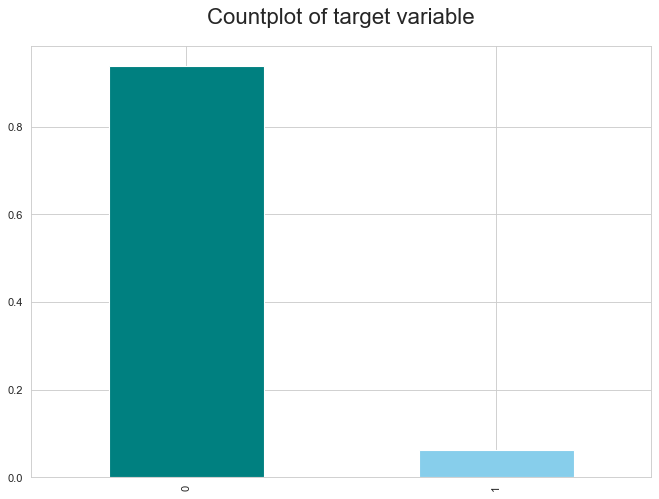

In [10]:
print(f"Tagret Variable:\n{data.target.value_counts(normalize=True)}")
plt.figure(figsize=(10, 7), dpi=80)
plt.title("Countplot of target variable", size = 20, pad = 20)
data.target.value_counts(normalize=True).plot.bar(color=['teal', 'skyblue'])
plt.show()

## Work on sample / fraction of the population data:

In [15]:
SAMPLE_SIZE = 100_000
sample_df = data.sample(SAMPLE_SIZE, random_state=42)
sample_df.drop(columns=['qid'], inplace=True)
sample_df.reset_index(drop=True)

,question_text,target
0,What is the most effective classroom managemen...,0
1,Can I study abroad after 10th class from Bangl...,0
2,How can I make friends as a college junior?,0
3,How do I download free APK Minecraft: Pocket E...,0
4,"Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...
99995,How do I research list of reliable charcoal im...,0
99996,"What are petroleum products, and what is petro...",0
99997,What are some services that will let you quick...,0
99998,What credit card processors do online marketpl...,0


## Text Preprocessing Techniques

Outline:

1. Understand the bag of words model
2. Tokenization
3. Stop word removal
4. Stemming

In [16]:
sample_df.target.value_counts(normalize=True)

0    0.93962
1    0.06038
Name: target, dtype: float64

## Cleaning the question_text column.

In [17]:
# -- lowercase the text data: good for stopwords remvoal --
sample_df['clean'] = sample_df['question_text'].apply(lambda x: " ".join(x.lower() for x in x.split("-")))
sample_df

,question_text,target,clean
443046,What is the most effective classroom managemen...,0,what is the most effective classroom managemen...
947549,Can I study abroad after 10th class from Bangl...,0,can i study abroad after 10th class from bangl...
523769,How can I make friends as a college junior?,0,how can i make friends as a college junior?
949821,How do I download free APK Minecraft: Pocket E...,0,how do i download free apk minecraft: pocket e...
1030397,"Like Kuvera, is ""Groww"" also a free online inv...",0,"like kuvera, is ""groww"" also a free online inv..."
...,...,...,...
998930,How do I research list of reliable charcoal im...,0,how do i research list of reliable charcoal im...
66641,"What are petroleum products, and what is petro...",0,"what are petroleum products, and what is petro..."
90024,What are some services that will let you quick...,0,what are some services that will let you quick...
130113,What credit card processors do online marketpl...,0,what credit card processors do online marketpl...


In [18]:
sample_df['clean'] = sample_df['clean'].str.replace(r'[^\w\s]', '', regex=True)
sample_df['clean'] = sample_df['clean'].str.replace(r'[0-9]', '', regex=True)
sample_df[sample_df['target'] == 1]['clean'].values[:10]

array(['is yahoo owned by the jews',
       'if macedonia is supposedly purely greek and so important to greece then why they have an english cross and not the vergina sun on their flag',
       'this is a question for muslims because american women dress very open do they deserve to get raped when it happens and is it encouraged i am not trying to be sick or funny just want a honest answer',
       'could the numerous acts of arms being severed in the star wars franchise be metaphors for the scientific procedure of castration',
       'should plus size women wear dresses and skirts only',
       'who carried out most terrorist attacks on the usa muslims or non muslims',
       'why do we constantly get questions from gun grabbing trolls in an attempt to upset the pro a crowd',
       'does tamil brahmins have more entrepreneurship in their genes compared to telugu brahmins',
       'do all atheists want to be immortal',
       'if most nice guys are aspergers and nice guys are manipul

In [19]:
sample_df[sample_df['target'] == 0].clean.values[-10:]

array(['is there any brothel in nashik',
       'am i engaging in harassment when i ask out a crush over text',
       'should christian churches in western countries allow teenagers to have sex in the church after the evening mass',
       'how is the phrase tough break used',
       'how should i prepare for theresa mays new internet regulation policies',
       'how do i research list of reliable charcoal importers',
       'what are petroleum products and what is petroleum used for',
       'what are some services that will let you quickly separate parts of a video at the five minute and ten minute mark into two separate videos',
       'what credit card processors do online marketplaces use',
       'on which number system does a computer work'], dtype=object)

## Remove stop words:

In [20]:
# -- remove stopwords --
stoppies = stopwords.words("english")

In [21]:
sample_df['clean'] = sample_df['clean'].apply(lambda x: " ".join(x for x in str.split(x) if x not in stoppies))
sample_df[sample_df['target'] == 1]['clean'].values[:10]

array(['yahoo owned jews',
       'macedonia supposedly purely greek important greece english cross vergina sun flag',
       'question muslims american women dress open deserve get raped happens encouraged trying sick funny want honest answer',
       'could numerous acts arms severed star wars franchise metaphors scientific procedure castration',
       'plus size women wear dresses skirts',
       'carried terrorist attacks usa muslims non muslims',
       'constantly get questions gun grabbing trolls attempt upset pro crowd',
       'tamil brahmins entrepreneurship genes compared telugu brahmins',
       'atheists want immortal',
       'nice guys aspergers nice guys manipulative mean aspergers manipulative'],
      dtype=object)

In [22]:
# -- correct spellings -- : Stopped -- takes a lot of time, 10-15 minutes 
# sample_df['clean'] = sample_df['clean'].apply(lambda x: " ".join(str(TextBlob(x).correct())))
# sample_df[sample_df['target'] == 1]['clean'].values[:10]

## EDA:

- Using __TextBlob__ to calculate sentiment polarity which lies in the range of [-1,1] where 1 means positive sentiment and -1 means a negative sentiment.
- Create new feature for the length of the review.

- Create new feature for the word count of the review

In [23]:
sample_df[sample_df['target'] == 1].head(20).reset_index(drop=True)

,question_text,target,clean
0,Is Yahoo owned by the Jews?,1,yahoo owned jews
1,"If Macedonia is supposedly ""purely"" Greek and ...",1,macedonia supposedly purely greek important gr...
2,This is a question for Muslims? Because Americ...,1,question muslims american women dress open des...
3,Could the numerous acts of arms being severed ...,1,could numerous acts arms severed star wars fra...
4,Should plus-size women wear dresses and skirts...,1,plus size women wear dresses skirts
5,Who carried out most terrorist attacks on the ...,1,carried terrorist attacks usa muslims non muslims
6,Why do we constantly get questions from gun-gr...,1,constantly get questions gun grabbing trolls a...
7,Does Tamil Brahmins have more entrepreneurship...,1,tamil brahmins entrepreneurship genes compared...
8,Do all atheists want to be immortal?,1,atheists want immortal
9,"If most ""nice guys"" are Asperger's and ""nice g...",1,nice guys aspergers nice guys manipulative mea...


## Implement Bag of Words:

### Bag of Words Intuition

1. Create a list of all the words across all the text documents
2. You convert each document into vector counts of each word


Limitations:
1. There may be too many words in the dataset
2. Some words may occur too frequently
3. Some words may occur very rarely or only once
4. A single word may have many forms (go, gone, going or bird vs. birds)

## Tokenizaton:

- Splitting a document into words and separators.

In [24]:
def tokenizer(text: str) -> list:
    stemmer = SnowballStemmer(language='english')
    return [stemmer.stem(word) for word in word_tokenize(text)]

In [25]:
vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenizer, max_features=1000, )

In [26]:
%%time
vectorizer.fit(sample_df.clean,)

CPU times: total: 20.8 s
Wall time: 21.2 s


CountVectorizer(max_features=1000,
                tokenizer=<function tokenizer at 0x00000242207A2290>)

In [27]:
len(vectorizer.vocabulary_)

1000

In [28]:
vectorizer.get_feature_names_out()[:100]

array(['abl', 'abroad', 'abus', 'academ', 'accept', 'access',
       'accomplish', 'accord', 'account', 'achiev', 'act', 'action',
       'activ', 'actor', 'actual', 'ad', 'add', 'address', 'admiss',
       'adult', 'advanc', 'advantag', 'advic', 'affect', 'africa',
       'african', 'age', 'agre', 'air', 'allow', 'almost', 'alon',
       'alreadi', 'also', 'altern', 'alway', 'amazon', 'america',
       'american', 'amount', 'analysi', 'android', 'anim', 'anoth',
       'answer', 'anti', 'anxieti', 'anyon', 'anyth', 'apart', 'app',
       'appear', 'appl', 'appli', 'applic', 'approach', 'arab', 'area',
       'arent', 'arm', 'armi', 'around', 'art', 'asian', 'ask', 'associ',
       'atheist', 'attack', 'attend', 'attract', 'australia', 'avail',
       'averag', 'avoid', 'away', 'b', 'babi', 'back', 'bad', 'ball',
       'ban', 'bangalor', 'bank', 'base', 'basic', 'beauti', 'becom',
       'begin', 'behind', 'believ', 'benefit', 'best', 'better', 'big',
       'biggest', 'bill', 'bit', 

In [29]:
%%time
inputs = vectorizer.transform(sample_df.clean)

CPU times: total: 19.5 s
Wall time: 19.5 s


In [30]:
inputs.shape

(100000, 1000)

In [31]:
inputs

<20x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 69 stored elements in Compressed Sparse Row format>

## ML Model for Classification:

In [34]:
train_inputs, val_inputs, train_target, val_target = split(inputs, sample_df.target, test_size=.30, random_state=42)

In [35]:
train_inputs.shape

(70000, 1000)

## Train Logistic Regression:

In [38]:
MAX_ITER = 1000
model = LogisticRegression(max_iter=MAX_ITER, solver='saga')

CPU times: total: 1.41 s
Wall time: 1.41 s


LogisticRegression(max_iter=1000, solver='saga')

In [ ]:
%%time
model.fit(train_inputs, train_target)

In [43]:
train_preds = model.predict(train_inputs)

print(f"Train accuracy: {(accuracy_score(train_target, train_preds)):.3f}", 
      f"f1-score: {(f1_score(train_target, train_preds)):.3f}", 
      sep="\n")

Train accuracy: 0.949

f1-score: 0.415


In [44]:
val_preds = model.predict(val_inputs)

print(f"Train accuracy: {(accuracy_score(val_target, val_preds)):.3f}", 
      f"f1-score: {(f1_score(val_target, val_preds)):.3f}", 
      sep="\n")

Train accuracy: 0.946

f1-score: 0.388


In [45]:
sincere_df.question_text.values[:10]

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
       'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
       'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
       'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
       'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
       'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something g

In [46]:
sincere_df.target.values[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [47]:
model.predict(vectorizer.transform(sincere_df.question_text.values[:10]))

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [48]:
insincere_df.question_text.values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

In [49]:
model.predict(vectorizer.transform(insincere_df.question_text.values[:10]))

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0], dtype=int64)

## Make predictions on test dataset and submit on Kaggle:

In [50]:
test_df = pd.read_csv('../data/test.csv')
test_df

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [51]:
test_df['clean'] = test_df['question_text'].str.replace(r'[^\w\s]', '', regex=True)
test_df['clean'] = test_df['clean'].str.replace(r'[0-9]', '', regex=True)
test_df['clean'] = test_df['clean'].apply(lambda x: " ".join(x.lower() for x in x.split("-")))

test_df.head(10)

,qid,question_text,clean
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,when should i apply for rv college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...,what is it really like to be a nurse practitioner
3,000086e4b7e1c7146103,Who are entrepreneurs?,who are entrepreneurs
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,is education really making good people nowadays
5,000101884c19f3515c1a,How do you train a pigeon to send messages?,how do you train a pigeon to send messages
6,00010f62537781f44a47,What is the currency in Langkawi?,what is the currency in langkawi
7,00012afbd27452239059,"What is the future for Pandora, can the busine...",what is the future for pandora can the busines...
8,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,my voice range is ac my chest voice goes up to...
9,000156468431f09b3cae,How much does a tutor earn in Bangalore?,how much does a tutor earn in bangalore


In [52]:
test_inputs = vectorizer.transform(test_df.clean)

In [53]:
test_preds = model.predict(test_inputs)

In [54]:
submission_df = pd.read_csv('../data/sample_submission.csv')
submission_df.head(10)

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
5,000101884c19f3515c1a,0
6,00010f62537781f44a47,0
7,00012afbd27452239059,0
8,00014894849d00ba98a9,0
9,000156468431f09b3cae,0


In [55]:
submission_df.prediction = test_preds

In [56]:
submission_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [57]:
submission_df.prediction.value_counts()

0    366043
1      9763
Name: prediction, dtype: int64

In [58]:
# submission_df.to_csv('../data/kaggle_quora_submission.csv', index=None)

In [60]:
test_df.drop(columns=['question_text'], inplace=True)

In [62]:
test_df['predictions'] = test_preds

In [69]:
test_df[test_df.predictions == 0]['clean'].values[:10]

array(['why do so many women become so rude and arrogant when they get just a little bit of wealth and power',
       'when should i apply for rv college of engineering and bms college of engineering should i wait for the comedk result or am i supposed to apply before the result',
       'what is it really like to be a nurse practitioner',
       'who are entrepreneurs',
       'is education really making good people nowadays',
       'how do you train a pigeon to send messages',
       'what is the currency in langkawi',
       'what is the future for pandora can the business reduce its debt',
       'my voice range is ac my chest voice goes up to f included sample in my higher chest range what is my voice type',
       'how much does a tutor earn in bangalore'], dtype=object)

In [68]:
test_df

,qid,clean,predictions
0,0000163e3ea7c7a74cd7,why do so many women become so rude and arroga...,0
1,00002bd4fb5d505b9161,when should i apply for rv college of engineer...,0
2,00007756b4a147d2b0b3,what is it really like to be a nurse practitioner,0
3,000086e4b7e1c7146103,who are entrepreneurs,0
4,0000c4c3fbe8785a3090,is education really making good people nowadays,0
...,...,...,...
375801,ffff7fa746bd6d6197a9,how many countries listed in gold import in indua,0
375802,ffffa1be31c43046ab6b,is there an alternative to dresses on formal p...,0
375803,ffffae173b6ca6bfa563,where i can find best friendship quotes in telugu,0
375804,ffffb1f7f1a008620287,what are the causes of refraction of light,0


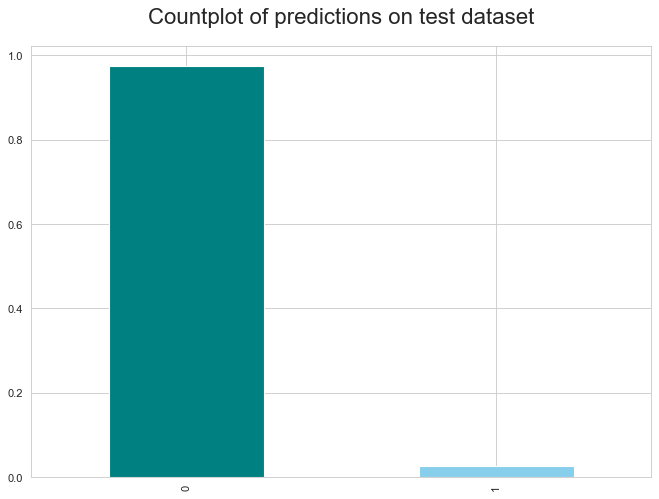

In [71]:
plt.figure(figsize=(10, 7), dpi=80)
test_df.predictions.value_counts(normalize=True).plot.bar(color=['teal', 'skyblue'])
plt.title("Countplot of predictions on test dataset", size = 20, pad = 20)
plt.show()

- Model can be more accurate.
- Target variable/class is imbalanced on which model is trained.
- balance target variable and train model once again.
- Move towards advanced models for the better accuracy and generalisation.